In [184]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import MultiKelly #seperate module
import pandas_profiling
pd.set_option('display.max_columns', 500)

plt.xkcd() # PLOT STYLING
# plt.style.use('seaborn') #UNCOMMENT IF PREFERRED
%matplotlib inline

### IMPORT DATA

In [130]:
df = pd.read_excel('Paddock and Tips Index Data for Cohort 4 exported on Sep 17, 2020.xlsx', sheet_name='paddock & Tips Index Data comb')

In [185]:
pandas_profiling.ProfileReport( df )

### FUNCTIONS

In [131]:
def threshold_change(grp, prob_col, return_col, colname, threshold):
    g = grp.copy()
    if (round(g[prob_col].max( ),2) > threshold):
        g[colname] = g[return_col]
        return g
    else:
        g[colname] = np.zeros_like(g[return_col])
        return g
    
##################################################################
    
def _get_model_earnings(grp, prob_col, colname):
    g = grp.copy()
    model_guess = (g[prob_col] == g[prob_col].max( ))
    g[colname] = model_guess * g['DOLLAR_RETURN_WIN']
    return g

def _get_odds_earnings(grp):
    g = grp.copy()
    odds_guess = (g['N_CLOSING_ODDS'] == g['N_CLOSING_ODDS'].min())
    g['ODDS_EARNINGS'] = odds_guess * g['DOLLAR_RETURN_WIN']
    return g

def _get_tips_earnings(grp):
    g = grp.copy()
    odds_guess = (g['RACE_DAY_TIPS_INDEX'] == g['RACE_DAY_TIPS_INDEX'].min())
    g['TIPS_EARNINGS'] = odds_guess * g['DOLLAR_RETURN_WIN']
    return g

##################################################################

def calculate_returns_per_dollar_place(winning_odds, placing_odds, rank):
    rank = pd.Series(rank)
    winning = (rank == 1) * (winning_odds/10 - 1)
    placed = rank.isin([2,3]) * (placing_odds/10 - 1)
    losing = (rank > 3)
    return winning + placed - losing

def calculate_returns_per_dollar(winning_odds, rank):
    rank = pd.Series(rank)
    winning = (rank == 1) * (winning_odds/10 - 1)
    losing = (rank > 1)
    return winning - losing

In [4]:
df.head()

,RACE_DATE_ID,RACE_ID,HORSE_ID,RANK,N_CLOSING_ODDS,N_PLACE_CLOSING_ODDS,N_LENGTHS_BEHIND_WINNER,TRAINER_A,TRAINER_B,TRAINER_C,TRAINER_D,TRAINER_E,TRAINER_F,TRAINER_G,TRAINER_H,TRAINER_I,TRAINER_J,TRAINER_K,TRAINER_L,TRAINER_M,TRAINER_N,TRAINER_O,TRAINER_P,TRAINER_Q,TRAINER_R,TRAINER_S,TRAINER_T,TRAINER_U,TRAINER_V,ST_FLAG,ATT_1,ATT_2,ATT_3,ATT_4,ATT_5,ATT_6,FIT_1,FIT_2,FIT_3,FIT_4,WALK_1,WALK_2,WALK_3,WALK_4,SIZE_1,SIZE_2,SIZE_3,SIZE_4,SIZE_5,SIZE_6,LOOK_1,LOOK_2,LOOK_3,LOOK_4,COAT_2,COAT_3,COAT_4,COAT_5,COAT_6,PER_1,PER_2,PER_3,PER_4,BAN_1,BAN_2,BAN_3,BAN_4,HAND_1,HAND_2,GEN_1,GEN_2,GEN_3,GEN_4,TIP_3,TIP_1,TIP_4,TIP_5,TIP_2,TIP_6,RANKBW_1,RANKBW_2,RANKBW_3,BWBAND_1,BWBAND_2,BWBAND_3,BWBAND_4,BWBAND_5,BWBAND_6,CHBW_1,CHBW_2,CHBW_3,RACE_DATE,RACEREF,HORSE,TRAINER,STARTER_STATUS,PLC,RACE_DATE_1,RACENO,HORSENO_IN_RACE,HORSE_1,N_CLOSING_ODDS_1,N_PLACE_CLOSING_ODDS_1,RANK_1,N_LENGTHS_BEHIND_WINNER_1,INITIAL_TIPS_INDEX,NORMALIZED_PROB_INITIAL_TIPS_INDEX,RANK_INITIAL_TIPS_INDEX,RANK_1_INITIAL_TIPS_INDEX,RANK_2_INITIAL_TIPS_INDEX,RANK_3_INITIAL_TIPS_INDEX,RANK_4_INITIAL_TIPS_INDEX,RANK_5_INITIAL_TIPS_INDEX,RANK_6_INITIAL_TIPS_INDEX,RANK_7_INITIAL_TIPS_INDEX,RANK_8_INITIAL_TIPS_INDEX,BAND_NORMALIZED_PROB_INITIAL_TIPS_INDEX,BAND_1_NORMALIZED_PROB_INITIAL_TIPS_INDEX,BAND_2_NORMALIZED_PROB_INITIAL_TIPS_INDEX,BAND_3_NORMALIZED_PROB_INITIAL_TIPS_INDEX,BAND_45_NORMALIZED_PROB_INITIAL_TIPS_INDEX,BAND_67_NORMALIZED_PROB_INITIAL_TIPS_INDEX,BAND_89_NORMALIZED_PROB_INITIAL_TIPS_INDEX,BAND_101112_NORMALIZED_PROB_INITIAL_TIPS_INDEX,BAND_13141516_NORMALIZED_PROB_INITIAL_TIPS_INDEX,RACE_DAY_TIPS_INDEX,NORMALIZED_PROB_RACE_DAY_TIPS_INDEX,RANK_RACE_DAY_TIPS_INDEX,RANK_1_RACE_DAY_TIPS_INDEX,RANK_2_RACE_DAY_TIPS_INDEX,RANK_3_RACE_DAY_TIPS_INDEX,RANK_4_RACE_DAY_TIPS_INDEX,RANK_5_RACE_DAY_TIPS_INDEX,RANK_6_RACE_DAY_TIPS_INDEX,RANK_7_RACE_DAY_TIPS_INDEX,RANK_8_RACE_DAY_TIPS_INDEX,BAND_NORMALIZED_PROB_RACE_DAY_TIPS_INDEX,BAND_1_NORMALIZED_PROB_RACE_DAY_TIPS_INDEX,BAND_2_NORMALIZED_PROB_RACE_DAY_TIPS_INDEX,BAND_3_NORMALIZED_PROB_RACE_DAY_TIPS_INDEX,BAND_45_NORMALIZED_PROB_RACE_DAY_TIPS_INDEX,BAND_67_NORMALIZED_PROB_RACE_DAY_TIPS_INDEX,BAND_89_NORMALIZED_PROB_RACE_DAY_TIPS_INDEX,BAND_101112_NORMALIZED_PROB_RACE_DAY_TIPS_INDEX,BAND_13141516_NORMALIZED_PROB_RACE_DAY_TIPS_INDEX,DUPLCATED_RANK,PLACE_FLAG,WIN_FLAG,RACEREF_1
0,Day 1788,190,13950,11,130,34.0,4.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,2020-07-15,39820,POLYMER LUCK,K H Ting,NaN,NaN,2020-07-15,1,1,POLYMER LUCK,130,34.0,11,4.50,28.5,0.0340,6,0,0,0,0,0,1,0,0,13,0,0,0,0,0,0,0,1,18.9,0.0512,4,0,0,0,1,0,0,0,0,12,0,0,0,0,0,0,1,0,11.0,0,0,39820
1,Day 1788,190,13190,2,37,15.0,0.08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,2,1,2,1,0,0,0,0,1,0,0,0,0,1,0,9,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,2020-07-15,39820,BUNDLE OF ENERGY,D J Hall,NaN,NaN,2020-07-15,1,2,BUNDLE OF ENERGY,37,15.0,2,0.08,2.5,0.3878,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,2.9,0.3334,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,2.0,1,0,39820
2,Day 1788,190,13654,4,100,35.5,1.75,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,2020-07-15,39820,HAY RUN,L Ho,NaN,NaN,2020-07-15,1,3,HAY RUN,100,35.5,4,1.75,14.0,0.0692,4,0,0,0,1,0,0,0,0,10,0,0,0,0,0,0,1,0,20.6,0.0469,5,0,0,0,0,1,0,0,0,12,0,0,0,0,0,0,1,0,4.0,0,0,39820
3,Day 1788,190,20630,3,100,34.0,1.25,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,2020-07-15,39820,BABY STORM,L Ho,NaN,NaN,2020-07-15,1,4,BABY STORM,100,34.0,3,1.25,22.3,0.0435,5,0,0,0,0,1,0,0,0,12,0,0,0,0,0,0,1,0,37.1,0.0261,6,0,0,0,0,0,1,0,0,15,0,0,0,0,0,0,0,1,3.0,1,0,39820
4,Day 1788,190,20657,12,470,125.5,5.00,0,0,0,0,0,0,0,0,0,0

In [132]:
df.drop(['RACE_DATE_ID', 'HORSE', 'TRAINER', 'STARTER_STATUS', 'PLC', 'RACE_DATE_1', 'HORSE_1', 'N_CLOSING_ODDS_1', 'N_PLACE_CLOSING_ODDS_1', 'RANK_1', 'N_LENGTHS_BEHIND_WINNER_1', 'DUPLCATED_RANK', 'RACEREF_1', 
        ], axis=1, inplace=True)

In [133]:
df['N_PLACE_CLOSING_ODDS'] = df.apply(lambda row: (row['N_CLOSING_ODDS'] / 2) if np.isnan(row['N_PLACE_CLOSING_ODDS']) else row['N_PLACE_CLOSING_ODDS'],axis=1)

In [ ]:
import datetime
df['RACE_DATE'] = pd.to_datetime(df.RACE_DATE)

In [147]:
for col in df:
    if df[col].isna().sum() > 0:
        print(col)

### FULL DATASET TEST/TRAIN SPLIT

In [8]:
y = df.WIN_FLAG

In [9]:
from sklearn.model_selection import GroupShuffleSplit
train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7).split(df, y, groups=df['RACE_DATE']))
train_x = df.iloc[train_inds]
test_x = df.iloc[test_inds]
train_y = y.iloc[train_inds]
test_y = y.iloc[test_inds]

In [10]:
#Columns to drop for logistic
drop_col = ['RACE_ID', 'RANK','RACE_DATE', 'RACENO', 'HORSENO_IN_RACE', 'RANK_1_INITIAL_TIPS_INDEX',
       'RACEREF', 'RANK_2_INITIAL_TIPS_INDEX', 'RANK_3_INITIAL_TIPS_INDEX',
       'RANK_4_INITIAL_TIPS_INDEX', 'RANK_5_INITIAL_TIPS_INDEX',
       'RANK_6_INITIAL_TIPS_INDEX', 'RANK_7_INITIAL_TIPS_INDEX',
       'RANK_8_INITIAL_TIPS_INDEX', 'BAND_1_NORMALIZED_PROB_INITIAL_TIPS_INDEX',
       'BAND_2_NORMALIZED_PROB_INITIAL_TIPS_INDEX',
       'BAND_3_NORMALIZED_PROB_INITIAL_TIPS_INDEX',
       'BAND_45_NORMALIZED_PROB_INITIAL_TIPS_INDEX',
       'BAND_67_NORMALIZED_PROB_INITIAL_TIPS_INDEX',
       'BAND_89_NORMALIZED_PROB_INITIAL_TIPS_INDEX',
       'BAND_101112_NORMALIZED_PROB_INITIAL_TIPS_INDEX',
       'BAND_13141516_NORMALIZED_PROB_INITIAL_TIPS_INDEX',
        'RANK_1_RACE_DAY_TIPS_INDEX',
       'RANK_2_RACE_DAY_TIPS_INDEX', 'RANK_3_RACE_DAY_TIPS_INDEX',
       'RANK_4_RACE_DAY_TIPS_INDEX', 'RANK_5_RACE_DAY_TIPS_INDEX',
       'RANK_6_RACE_DAY_TIPS_INDEX', 'RANK_7_RACE_DAY_TIPS_INDEX',
       'RANK_8_RACE_DAY_TIPS_INDEX','BAND_1_NORMALIZED_PROB_RACE_DAY_TIPS_INDEX',
       'BAND_2_NORMALIZED_PROB_RACE_DAY_TIPS_INDEX',
       'BAND_3_NORMALIZED_PROB_RACE_DAY_TIPS_INDEX',
       'BAND_45_NORMALIZED_PROB_RACE_DAY_TIPS_INDEX',
       'BAND_67_NORMALIZED_PROB_RACE_DAY_TIPS_INDEX',
       'BAND_89_NORMALIZED_PROB_RACE_DAY_TIPS_INDEX',
       'BAND_101112_NORMALIZED_PROB_RACE_DAY_TIPS_INDEX',
       'BAND_13141516_NORMALIZED_PROB_RACE_DAY_TIPS_INDEX',
       'PLACE_FLAG', 'WIN_FLAG', 'N_LENGTHS_BEHIND_WINNER'
        ]

### TRAIN / TEST SPLIT FOR LOGISTIC

In [11]:
train_LG = train_x.drop(drop_col, axis=1)
test_LG = test_x.drop(drop_col, axis=1)

### TRAIN / TEST SPLIT FOR RANDOM FOREST

In [12]:
train_RF = train_x.drop(['RACE_ID', 'RANK', 'RACE_DATE', 'RACEREF', 'RACENO', 'PLACE_FLAG', 'WIN_FLAG', 'N_LENGTHS_BEHIND_WINNER'], axis=1)
test_RF = test_x.drop(['RACE_ID', 'RANK', 'RACE_DATE', 'RACEREF', 'RACENO', 'PLACE_FLAG', 'WIN_FLAG', 'N_LENGTHS_BEHIND_WINNER'], axis=1)

### RANDOM FOREST TRAINING

In [154]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

randomForest = RandomForestClassifier(class_weight='balanced')

k5s = StratifiedKFold(n_splits=5, shuffle = False)

grid_para_forest = [{
    "max_depth": range(2, 4),
    "n_estimators": [10, 25, 50],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": range(2, 5),
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int),
    "random_state": [0]}]

grid_search_forest = GridSearchCV(randomForest, grid_para_forest, scoring= 'f1', cv=k5s, n_jobs=-1)

In [14]:
grid_search_forest.fit(train_RF, train_y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': range(2, 4),
                          'min_samples_leaf': range(2, 5),
                          'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]),
                          'n_estimators': [10, 25, 50], 'random_state': [0]}],
             scoring='f1')

In [15]:
grid_search_forest.score(train_RF, train_y)

0.27597095042627096

In [16]:
grid_search_forest.best_estimator_.score(test_RF, test_y)

0.7116374871266735

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_y, grid_search_forest.best_estimator_.predict(test_RF))

array([[1279,  505],
       [  55,  103]])

In [18]:
win_prob_rf = grid_search_forest.best_estimator_.predict_proba(test_RF)
win_prob_rf = win_prob_rf[:,1]

In [19]:
# CREATE COLUMN FOR THE WIN PROBABILITY OF EACH HORSE IN EACH RACE

test_x['RF_WIN_PROBS'] = win_prob_rf

/Users/Brancusi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### LOGISTIC TRAINING

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logit = LogisticRegression( class_weight='balanced', random_state=0, solver='liblinear' )

params = {'C':np.logspace(-4,4, 20)}
gs_logit = GridSearchCV(logit, params, cv=3)

In [21]:
gs_logit.fit(train_LG, train_y)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=0, solver='liblinear'),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])})

In [22]:
confusion_matrix(test_y, gs_logit.best_estimator_.predict(test_LG))

array([[1225,  559],
       [  49,  109]])

In [23]:
win_prob_lg = gs_logit.best_estimator_.predict_proba( test_LG )
win_prob_lg = win_prob_lg[:,1]

In [24]:
#CREATE COLUMN FOR WIN PROBABILITY OF EACH HORSE IN EACH RACE

test_x['LG_WIN_PROBS'] = win_prob_lg

/Users/Brancusi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [182]:
x = list(zip(train_LG.columns, gs_logit.best_estimator_.coef_[0]))
s = sorted(x, key = lambda x: -abs(x[1]))

### GRAPH RESULTS - PADDOCK & TIPS DATA

In [136]:
df_prob = test_x.copy()
df_prob['ODDS_PROB'] = (10/((df_prob['N_CLOSING_ODDS'])-1))
df_prob['PAY_ODDS'] = df_prob['N_CLOSING_ODDS']/1.24
df_prob['PAY_PLACE_ODDS'] = df_prob['N_PLACE_CLOSING_ODDS']/1.24
df_prob['DOLLAR_RETURN_WIN'] = calculate_returns_per_dollar(df_prob['PAY_ODDS'], df_prob['RANK'])

In [137]:
df_prob = df_prob.groupby('RACE_ID').apply(_get_model_earnings, 'RF_WIN_PROBS', 'DOLLAR_RETURN_RF_WIN').reset_index(drop=True)
df_prob = df_prob.groupby('RACE_ID').apply(_get_model_earnings, 'LG_WIN_PROBS', 'DOLLAR_RETURN_LG_WIN').reset_index(drop=True)

In [138]:
df_prob = df_prob.groupby('RACE_ID').apply(_get_odds_earnings).reset_index(drop=True)
df_prob = df_prob.groupby('RACE_ID').apply(_get_tips_earnings).reset_index(drop=True)

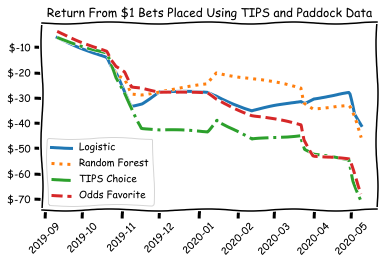

In [122]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots()

GROUP = df_prob.groupby(['RACE_DATE']).agg({'DOLLAR_RETURN_LG_WIN': 'sum', 'DOLLAR_RETURN_RF_WIN': 'sum', 
                                           'ODDS_EARNINGS': 'sum', 'TIPS_EARNINGS':'sum'}).reset_index()
GROUP

GROUP['TOTAL_LG'] = GROUP.DOLLAR_RETURN_LG_WIN.cumsum()
GROUP['TOTAL_RF'] = GROUP.DOLLAR_RETURN_RF_WIN.cumsum()
GROUP['TOTAL_TIPS'] = GROUP.TIPS_EARNINGS.cumsum()
GROUP['TOTAL_ODDS'] = GROUP.ODDS_EARNINGS.cumsum()

y = GROUP['RACE_DATE']

plt.plot(GROUP.RACE_DATE,GROUP['TOTAL_LG'], label='Logistic', linewidth=3, linestyle='solid')
plt.plot(GROUP.RACE_DATE,GROUP['TOTAL_RF'], label='Random Forest', linewidth=3, linestyle='dotted')
plt.plot(GROUP.RACE_DATE,GROUP['TOTAL_TIPS'], label='TIPS Choice', linewidth=3, linestyle='dashdot')
plt.plot(GROUP.RACE_DATE,GROUP['TOTAL_ODDS'], label='Odds Favorite', linewidth=3, linestyle='--')


formatter = ticker.FormatStrFormatter('$%1.0f')
ax.yaxis.set_major_formatter(formatter)

plt.gcf().subplots_adjust(bottom=0.23)
plt.legend()
plt.xticks(rotation=45)
plt.title('Return From $1 Bets Placed Using TIPS and Paddock Data')

# plt.savefig('Paddock_and_TIPS_final_pdf.pdf')

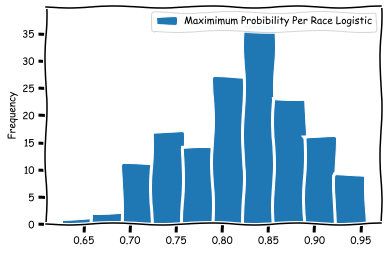

In [174]:
plotlg = df_prob.rename({'LG_WIN_PROBS':'Maximimum Probibility Per Race Logistic'}, axis=1).groupby('RACE_ID').agg({'Maximimum Probibility Per Race Logistic' : 'max'}).plot(kind='hist', bins=10, edgecolor='w', label='Maximimum Probibility Per Race')

fig = plotlg.get_figure()
# fig.savefig("max_win_prob.pdf")

### ADDING ENGINEERED FEATURES

In [40]:
ef = df.copy()

In [142]:
df_prob.RACE_DATE.dtype

dtype('<M8[ns]')

In [42]:
winner = dict(ef.groupby('HORSE_ID')['WIN_FLAG'].agg('sum'))
place = dict(ef.groupby('HORSE_ID')['PLACE_FLAG'].agg('sum'))
median_dist_behind_winner = dict(ef.groupby('HORSE_ID')['N_LENGTHS_BEHIND_WINNER'].agg('median'))

In [43]:
ef['TOTAL_WINS'] = ef['HORSE_ID'].apply(lambda x: winner.get(x))
ef['TOTAL_PLACE'] = ef['HORSE_ID'].apply(lambda x: place.get(x))
ef['MEDIAN_DIST_BEHIND_WINNER'] = ef['HORSE_ID'].apply(lambda x: median_dist_behind_winner.get(x))

ef['TOTAL_WINS'] = ef['TOTAL_WINS'].fillna(0)
ef['TOTAL_PLACE'] = ef['TOTAL_PLACE'].fillna(0)

In [45]:
placed_horse = df.loc[df.RANK <= 4]
placed_lengths = placed_horse.groupby('HORSE_ID').agg({'N_LENGTHS_BEHIND_WINNER' : 'mean'}).to_dict()['N_LENGTHS_BEHIND_WINNER']

ef['FOURTH_OR_BETTER_LENGTHS_BEHIND'] = ef.HORSE_ID.map( placed_lengths )
ef['FOURTH_OR_BETTER_LENGTHS_BEHIND'] = ef['FOURTH_OR_BETTER_LENGTHS_BEHIND'].fillna(ef.N_LENGTHS_BEHIND_WINNER.mean())

In [46]:
races_run_dict = ef.groupby('HORSE_ID')['HORSE_ID'].agg('count').to_dict()
ef['RACES_RUN_TOTAL'] = ef.HORSE_ID.map( races_run_dict )

In [47]:
ef['WIN_TO_RACE_RATIO'] = ef.TOTAL_WINS / ef.RACES_RUN_TOTAL
ef['PLACE_TO_RACE_RATIO'] = ef.TOTAL_PLACE / ef.RACES_RUN_TOTAL

### FULL TRAIN TEST SPLIT - ENGINEERED

In [48]:
from sklearn.model_selection import GroupShuffleSplit
y = ef.WIN_FLAG
train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7).split(df, y, groups=ef['RACE_DATE']))
train_xx = ef.iloc[train_inds]
test_xx = ef.iloc[test_inds]
train_yy = y.iloc[train_inds]
test_yy = y.iloc[test_inds]

### RANDOM FOREST SPLIT - ENGINEERED

In [49]:
train_RF_full = train_xx.drop(['RACE_ID', 'RANK', 'RACE_DATE', 'RACEREF', 'RACENO', 'PLACE_FLAG', 'WIN_FLAG', 'N_LENGTHS_BEHIND_WINNER'], axis=1)
test_RF_full = test_xx.drop(['RACE_ID', 'RANK', 'RACE_DATE', 'RACEREF', 'RACENO', 'PLACE_FLAG', 'WIN_FLAG', 'N_LENGTHS_BEHIND_WINNER'], axis=1)

### LOGISITC SPLIT - ENGINEERED

In [50]:
#USING SAME DROPPED COLUMNS AS ABOVE

train_LG_full = train_xx.drop(drop_col, axis=1)
test_LG_full = test_xx.drop(drop_col, axis=1)

### RANDOM FOREST TRAINING - ENGINEERED

In [51]:
grid_search_forest_full = GridSearchCV(randomForest, grid_para_forest, scoring= 'f1', cv=k5s, n_jobs=-1)

In [52]:
grid_search_forest_full.fit( train_RF_full, train_yy )

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': range(2, 4),
                          'min_samples_leaf': range(2, 5),
                          'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]),
                          'n_estimators': [10, 25, 50], 'random_state': [0]}],
             scoring='f1')

In [56]:
grid_search_forest_full.best_estimator_.score( test_RF_full, test_yy )

0.762615859938208

In [57]:
confusion_matrix(test_yy, grid_search_forest_full.best_estimator_.predict(test_RF_full))

array([[1345,  439],
       [  22,  136]])

In [58]:
win_prob_rf_full = grid_search_forest_full.best_estimator_.predict_proba(test_RF_full)
win_prob_rf_full= win_prob_rf_full[:,1]

In [68]:
## ADDING THE COLUMN TO THE ORIGINAL DATASET
df_prob['RF_WIN_PROBS_FULL'] = win_prob_rf_full

### LOGISTIC TRAINING - ENGINEERED

In [110]:
gs_logit_full = GridSearchCV(logit, params, cv=3)

In [61]:
gs_logit_full.fit( train_LG_full, train_yy)

/Users/Brancusi/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Brancusi/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=0, solver='liblinear'),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])})

In [62]:
gs_logit_full.best_estimator_.score( test_LG_full, test_yy )

0.7888774459320288

In [63]:
confusion_matrix(test_yy, gs_logit_full.best_estimator_.predict(test_LG_full))

array([[1410,  374],
       [  36,  122]])

In [64]:
win_prob_LG_full = gs_logit_full.best_estimator_.predict_proba(test_LG_full)
win_prob_LG_full = win_prob_LG_full[:,1]

In [69]:
#ADD COLUMN TO ORIGINAL DATASET
df_prob['LG_WIN_PROBS_FULL'] = win_prob_LG_full

### GRAPH ENGINEERED MODEL

In [70]:
df_prob = df_prob.groupby('RACE_ID').apply(_get_model_earnings, 'RF_WIN_PROBS_FULL', 'DOLLAR_RETURN_RF_WIN_FULL').reset_index(drop=True)
df_prob = df_prob.groupby('RACE_ID').apply(_get_model_earnings, 'LG_WIN_PROBS_FULL', 'DOLLAR_RETURN_LG_WIN_FULL').reset_index(drop=True)

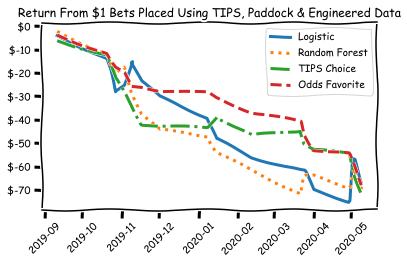

In [124]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots()

GROUP = df_prob.groupby(['RACE_DATE']).agg({'DOLLAR_RETURN_LG_WIN_FULL': 'sum', 'DOLLAR_RETURN_RF_WIN_FULL': 'sum', 
                                           'ODDS_EARNINGS': 'sum', 'TIPS_EARNINGS':'sum'}).reset_index()
GROUP

GROUP['TOTAL_LG_FULL'] = GROUP.DOLLAR_RETURN_LG_WIN_FULL.cumsum()
GROUP['TOTAL_RF_FULL'] = GROUP.DOLLAR_RETURN_RF_WIN_FULL.cumsum()
GROUP['TOTAL_TIPS_FULL'] = GROUP.TIPS_EARNINGS.cumsum()
GROUP['TOTAL_ODDS_FULL'] = GROUP.ODDS_EARNINGS.cumsum()

y = GROUP['RACE_DATE']

plt.plot(GROUP.RACE_DATE,GROUP['TOTAL_LG_FULL'], label='Logistic', linewidth=3, linestyle='solid')
plt.plot(GROUP.RACE_DATE,GROUP['TOTAL_RF_FULL'], label='Random Forest', linewidth=3, linestyle='dotted')
plt.plot(GROUP.RACE_DATE,GROUP['TOTAL_TIPS_FULL'], label='TIPS Choice', linewidth=3, linestyle='dashdot')
plt.plot(GROUP.RACE_DATE,GROUP['TOTAL_ODDS_FULL'], label='Odds Favorite', linewidth=3, linestyle='--')

ormatter = ticker.FormatStrFormatter('$%1.0f')
ax.yaxis.set_major_formatter(formatter)

plt.gcf().subplots_adjust(bottom=0.23)
plt.legend()
plt.xticks(rotation=45)
plt.title('Return From $1 Bets Placed Using TIPS, Paddock & Engineered Data')

plt.savefig('Paddock_TIPS_Engineered_pdf.pdf')

### USE ONLY PADDOCK DATA

In [85]:
train_x_pad = train_x.iloc[:,1:90]
test_x_pad = test_x.iloc[:,1:90]

In [86]:
train_x_pad.head()

,HORSE_ID,RANK,N_CLOSING_ODDS,N_PLACE_CLOSING_ODDS,N_LENGTHS_BEHIND_WINNER,TRAINER_A,TRAINER_B,TRAINER_C,TRAINER_D,TRAINER_E,TRAINER_F,TRAINER_G,TRAINER_H,TRAINER_I,TRAINER_J,TRAINER_K,TRAINER_L,TRAINER_M,TRAINER_N,TRAINER_O,TRAINER_P,TRAINER_Q,TRAINER_R,TRAINER_S,TRAINER_T,TRAINER_U,TRAINER_V,ST_FLAG,ATT_1,ATT_2,ATT_3,ATT_4,ATT_5,ATT_6,FIT_1,FIT_2,FIT_3,FIT_4,WALK_1,WALK_2,WALK_3,WALK_4,SIZE_1,SIZE_2,SIZE_3,SIZE_4,SIZE_5,SIZE_6,LOOK_1,LOOK_2,LOOK_3,LOOK_4,COAT_2,COAT_3,COAT_4,COAT_5,COAT_6,PER_1,PER_2,PER_3,PER_4,BAN_1,BAN_2,BAN_3,BAN_4,HAND_1,HAND_2,GEN_1,GEN_2,GEN_3,GEN_4,TIP_3,TIP_1,TIP_4,TIP_5,TIP_2,TIP_6,RANKBW_1,RANKBW_2,RANKBW_3,BWBAND_1,BWBAND_2,BWBAND_3,BWBAND_4,BWBAND_5,BWBAND_6,CHBW_1,CHBW_2,CHBW_3
0,13950,11,130,34.0,4.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
1,13190,2,37,15.0,0.08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,2,1,2,1,0,0,0,0,1,0,0,0,0,1,0,9,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,13654,4,100,35.5,1.75,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
3,20630,3,100,34.0,1.25,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,20657,12,470,125.5,5.00,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [87]:
train_x_pad.drop(['RANK', 'N_CLOSING_ODDS', 'N_PLACE_CLOSING_ODDS', 'N_LENGTHS_BEHIND_WINNER'], axis=1, inplace=True)
test_x_pad.drop(['RANK', 'N_CLOSING_ODDS', 'N_PLACE_CLOSING_ODDS', 'N_LENGTHS_BEHIND_WINNER'], axis=1, inplace=True)

### LOGISTIC TRAINING - PADDOCK

In [88]:
gs_logit_pad = GridSearchCV(logit, params, cv=3)

In [89]:
gs_logit_pad.fit( train_x_pad, train_y )

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=0, solver='liblinear'),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])})

In [90]:
gs_logit_pad.best_estimator_.score( test_x_pad, test_y )

0.6462409886714727

In [91]:
confusion_matrix(test_y, gs_logit_pad.best_estimator_.predict(test_x_pad))

array([[1159,  625],
       [  62,   96]])

In [92]:
win_prob_LG_pad = gs_logit_pad.best_estimator_.predict_proba(test_x_pad)
win_prob_LG_pad = win_prob_LG_pad[:,1]

In [93]:
# ADD COLUMN TO FULL DF
df_prob['LG_WIN_PROBS_PAD'] = win_prob_LG_pad

### RANDOM FOREST TRAINING - PADDOCK

In [94]:
grid_search_forest_pad = GridSearchCV(randomForest, grid_para_forest, scoring= 'f1', cv=k5s, n_jobs=-1)

In [95]:
grid_search_forest_pad.fit( train_x_pad, train_y )

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': range(2, 4),
                          'min_samples_leaf': range(2, 5),
                          'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]),
                          'n_estimators': [10, 25, 50], 'random_state': [0]}],
             scoring='f1')

In [96]:
grid_search_forest_pad.best_estimator_.score( test_x_pad, test_y )

0.6503604531410917

In [97]:
confusion_matrix(test_y, grid_search_forest_pad.best_estimator_.predict(test_x_pad))

array([[1175,  609],
       [  70,   88]])

In [98]:
win_prob_rf_pad = grid_search_forest_pad.best_estimator_.predict_proba(test_x_pad)
win_prob_rf_pad= win_prob_rf_pad[:,1]

In [99]:
# ADD COLUMN TO FULL DF
df_prob['RF_WIN_PROBS_PAD'] = win_prob_rf_pad

### GRAPH PADDOCK MODEL

In [100]:
df_prob = df_prob.groupby('RACE_ID').apply(_get_model_earnings, 'RF_WIN_PROBS_PAD', 'DOLLAR_RETURN_RF_WIN_PAD').reset_index(drop=True)
df_prob = df_prob.groupby('RACE_ID').apply(_get_model_earnings, 'LG_WIN_PROBS_PAD', 'DOLLAR_RETURN_LG_WIN_PAD').reset_index(drop=True)

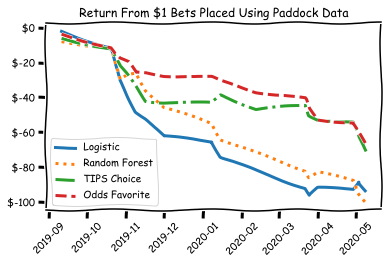

In [125]:
fig, ax = plt.subplots()

GROUP = df_prob.groupby(['RACE_DATE']).agg({'DOLLAR_RETURN_LG_WIN_PAD': 'sum', 'DOLLAR_RETURN_RF_WIN_PAD': 'sum', 
                                           'ODDS_EARNINGS': 'sum', 'TIPS_EARNINGS':'sum'}).reset_index()
GROUP

GROUP['TOTAL_LG_PAD'] = GROUP.DOLLAR_RETURN_LG_WIN_PAD.cumsum()
GROUP['TOTAL_RF_PAD'] = GROUP.DOLLAR_RETURN_RF_WIN_PAD.cumsum()
GROUP['TOTAL_TIPS_FULL'] = GROUP.TIPS_EARNINGS.cumsum()
GROUP['TOTAL_ODDS_FULL'] = GROUP.ODDS_EARNINGS.cumsum()

y = GROUP['RACE_DATE']

plt.plot(GROUP.RACE_DATE,GROUP['TOTAL_LG_PAD'], label='Logistic', linewidth=3, linestyle='solid')
plt.plot(GROUP.RACE_DATE,GROUP['TOTAL_RF_PAD'], label='Random Forest', linewidth=3, linestyle='dotted')
plt.plot(GROUP.RACE_DATE,GROUP['TOTAL_TIPS_FULL'], label='TIPS Choice', linewidth=3, linestyle='dashdot')
plt.plot(GROUP.RACE_DATE,GROUP['TOTAL_ODDS_FULL'], label='Odds Favorite', linewidth=3, linestyle='--')

ormatter = ticker.FormatStrFormatter('$%1.0f')
ax.yaxis.set_major_formatter(formatter)

plt.gcf().subplots_adjust(bottom=0.23)
plt.legend(loc='lower left')
plt.xticks(rotation=45)
plt.title('Return From $1 Bets Placed Using Paddock Data')

plt.savefig('Paddock_pdf.pdf')

### CHANGING THE THRESHOLD FOR PLACING A BET

##### USING LOGISITC REGRESSION WITH TIPS AND PADDOCK DATA

In [105]:
t = df_prob.copy()

In [106]:
t=t.groupby('RACE_ID').apply(threshold_change, 'LG_WIN_PROBS', 'DOLLAR_RETURN_LG_WIN', 'DOLLAR_RETURN_LG_WIN_60', .60).reset_index(drop=True)
t=t.groupby('RACE_ID').apply(threshold_change, 'LG_WIN_PROBS', 'DOLLAR_RETURN_LG_WIN', 'DOLLAR_RETURN_LG_WIN_70', .70).reset_index(drop=True)
t=t.groupby('RACE_ID').apply(threshold_change, 'LG_WIN_PROBS', 'DOLLAR_RETURN_LG_WIN', 'DOLLAR_RETURN_LG_WIN_80', .80).reset_index(drop=True)
t=t.groupby('RACE_ID').apply(threshold_change, 'LG_WIN_PROBS', 'DOLLAR_RETURN_LG_WIN', 'DOLLAR_RETURN_LG_WIN_90', .90).reset_index(drop=True)

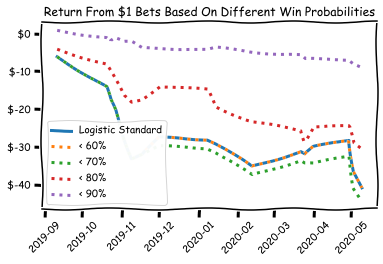

In [126]:
fig, ax = plt.subplots()

GROUP = t.groupby(['RACE_DATE']).agg({'DOLLAR_RETURN_LG_WIN_60': 'sum', 'DOLLAR_RETURN_LG_WIN_70': 'sum', 
                                           'DOLLAR_RETURN_LG_WIN_80': 'sum', 'DOLLAR_RETURN_LG_WIN_90': 'sum',
                                         'DOLLAR_RETURN_LG_WIN':'sum','ODDS_EARNINGS': 'sum', 'TIPS_EARNINGS':'sum'}).reset_index()
GROUP

GROUP['DOLLAR_RETURN_LG_WIN_60'] = GROUP.DOLLAR_RETURN_LG_WIN_60.cumsum()
GROUP['DOLLAR_RETURN_LG_WIN_70'] = GROUP.DOLLAR_RETURN_LG_WIN_70.cumsum()
GROUP['DOLLAR_RETURN_LG_WIN_80'] = GROUP.DOLLAR_RETURN_LG_WIN_80.cumsum()
GROUP['DOLLAR_RETURN_LG_WIN_90'] = GROUP.DOLLAR_RETURN_LG_WIN_90.cumsum()
GROUP['TOTAL_LG_FULL'] = GROUP.DOLLAR_RETURN_LG_WIN.cumsum()



y = GROUP['RACE_DATE']

plt.plot(GROUP.RACE_DATE,GROUP['TOTAL_LG_FULL'], label='Logistic Standard', linewidth=3, linestyle='solid')
plt.plot(GROUP.RACE_DATE,GROUP['DOLLAR_RETURN_LG_WIN_60'], label='< 60%', linewidth=3, linestyle='dotted')
plt.plot(GROUP.RACE_DATE,GROUP['DOLLAR_RETURN_LG_WIN_70'], label='< 70%', linewidth=3, linestyle='dotted')
plt.plot(GROUP.RACE_DATE,GROUP['DOLLAR_RETURN_LG_WIN_80'], label='< 80%', linewidth=3, linestyle='dotted')
plt.plot(GROUP.RACE_DATE,GROUP['DOLLAR_RETURN_LG_WIN_90'], label='< 90%', linewidth=3, linestyle='dotted')

formatter = ticker.FormatStrFormatter('$%1.0f')
ax.yaxis.set_major_formatter(formatter)

plt.gcf().subplots_adjust(bottom=0.23)
plt.legend(loc='lower left')
plt.xticks(rotation=45)
plt.title('Return From $1 Bets Based On Different Win Probabilities')

plt.savefig('Logistic_Percentages_Final_pdf.pdf')